In [18]:
%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np

#sys.path.append('../')
import pyqsofit.PyQSOFit
from astropy.io import fits,ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings
import importlib

importlib.reload(pyqsofit.PyQSOFit)

warnings.filterwarnings("ignore")

#QSOFit.set_mpl_style()

In [19]:
multiAGNpath="/disk/bifrost/yuanze/multiAGN"
psname1="UGC"
psname2="2369"
obj=3
instru="MUSE"
stab = ascii.read(multiAGNpath+"/sources.list",format="ipac")
field=psname1+psname2
sentry = stab[stab["Field"]==field]
RA=sentry["RA"].value#[43.507814008,43.507573386,43.50724857]
Dec=sentry["Dec"].value#[14.9700775,14.9708075,14.97041556]
datapath=os.path.join(multiAGNpath,psname1+psname2)
z = sentry["z_sys"][obj-1]
path_ex = datapath #os.path.join(pyqsofit.__path__[0], '..', 'example')

path_out = os.path.join(datapath, '{}_1D'.format(instru.split("_")[0]))


# Requried
data = np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))
lam = data[:,0]  # OBS wavelength [A]
#flux = data[:,1]*1e-3  # OBS flux [1e-17 erg/s/cm^2/A]
err = data[:,2]*1e-3  # 1 sigma error

#continuum
cont=np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_ppxfmodel_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))*1e20 # to 1e-20
contwave=np.loadtxt(os.path.join(path_out, "wave_ln_binned.txt"))
continterp=np.interp(lam,contwave,cont)
flux=(data[:,1]-continterp)*1e-3

In [66]:
np.prod([[1,4,2,5],[1,1,2,3]],axis=0)

array([ 1,  4,  4, 15])

## Fitting parameter setup

In [20]:

# create FITS file containing fitting parameter setup 
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    (5889.950, 'Ha', 4640, 6800, 'NaI5890', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 4, 0, 1, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 4, 0, 1, 0.1, 1),
    (5889.950, 'Ha', 4640, 6800, 'NaI5890w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 5, 0, 2, 0.2, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896w', 1, 1., 0.0, 1e1, 1e-5, 2.3e-7, 0.0169, -5e-3, 5e-3, 5, 0, 2, 0.1, 1),
    (6564.61, 'Ha', 4640, 6800, 'Ha_br',     2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, -0.015, 0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 4640, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.003, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
    (5875.621, 'Ha', 4640, 6800, 'HeI5876', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 1, 1, 0, 0.001, 1),
    
    

    
#    (8498.02, 'Ha', 6400, 6800, 'CaII8498', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8542.09, 'Ha', 6400, 6800, 'CaII8542', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8662.14, 'Ha', 6400, 6800, 'CaII8662', 1, 0.0,  -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
    
    (6564.61, 'Ha', 4640, 6800, 'Ha_naw',  1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7,  0.00169, -0.01, 0.01, 3, 3, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.003, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -5e-3, 5e-3, 3, 3, 0, 0.001, 1),

    #(4862.68, 'Ha', 4640, 6800, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,    0.01, 1, 1, 0, 0.002, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_naw', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,   0.01, 3, 3, 0, 0.002, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, -0.01,0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, -0.01,0.01, 3, 3, 0, 0.001, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, -0.01,0.01, 3, 3, 0, 0.002, 1)
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig, minvoff, maxvoff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['minvoff  '] = 'Lower Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['maxvoff  '] = 'Upper Limits on velocity offset from the central wavelength [lnlambda]'

hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    (19700.,20250.),
    (21700.,22250.)
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000,20000,20900]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_obj{}_{}.fits'.format(obj,instru)), overwrite=True)

In [16]:
Table(line_priors)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,minvoff,maxvoff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
5889.95,Ha,4640.0,6800.0,NaI5890,1,1.0,0.0,10.0,1e-05,2.3e-07,0.0169,-0.005,0.005,4,0,1,0.2,1
5895.924,Ha,4640.0,6800.0,NaI5896,1,1.0,0.0,10.0,1e-05,2.3e-07,0.0169,-0.005,0.005,4,0,1,0.1,1
5889.95,Ha,4640.0,6800.0,NaI5890w,1,1.0,0.0,10.0,1e-05,2.3e-07,0.0169,-0.005,0.005,5,0,2,0.2,1
5895.924,Ha,4640.0,6800.0,NaI5896w,1,1.0,0.0,10.0,1e-05,2.3e-07,0.0169,-0.005,0.005,5,0,2,0.1,1
6564.61,Ha,4640.0,6800.0,Ha_br,2,0.0,0.0,10000000000.0,0.005,0.0004,0.05,-0.015,0.015,0,0,0,0.05,1
6564.61,Ha,4640.0,6800.0,Ha_na,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,-0.01,0.01,1,1,0,0.002,1
6549.85,Ha,4640.0,6800.0,NII6549,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,-0.005,0.005,1,1,0,0.001,1
6585.28,Ha,4640.0,6800.0,NII6585,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,-0.005,0.005,1,1,0,0.003,1
6718.29,Ha,4640.0,6800.0,SII6718,1,0.0,0.0,10000000000.0,0.001,2.3e-07,0.00169,-0.005,0.005,1,1,0,0.001,1


## Start fitting

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.1      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Blamer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_op_norm          0        0    1e+10     None    False     None     None
Fe_op_shift         0    -0.01     0.01     None    False     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_uv_norm          0        0    1e+10     None    False     None     None
Fe_uv_shift         0    -0.01     0.01     None    False     None     None
PL_norm             0        0    1e+10     None    False     None     None
PL_slope         -1.5       -5        3     None    False     None     None
conti_a_0           0     -inf      inf     None    False     None     None
conti_a_1 

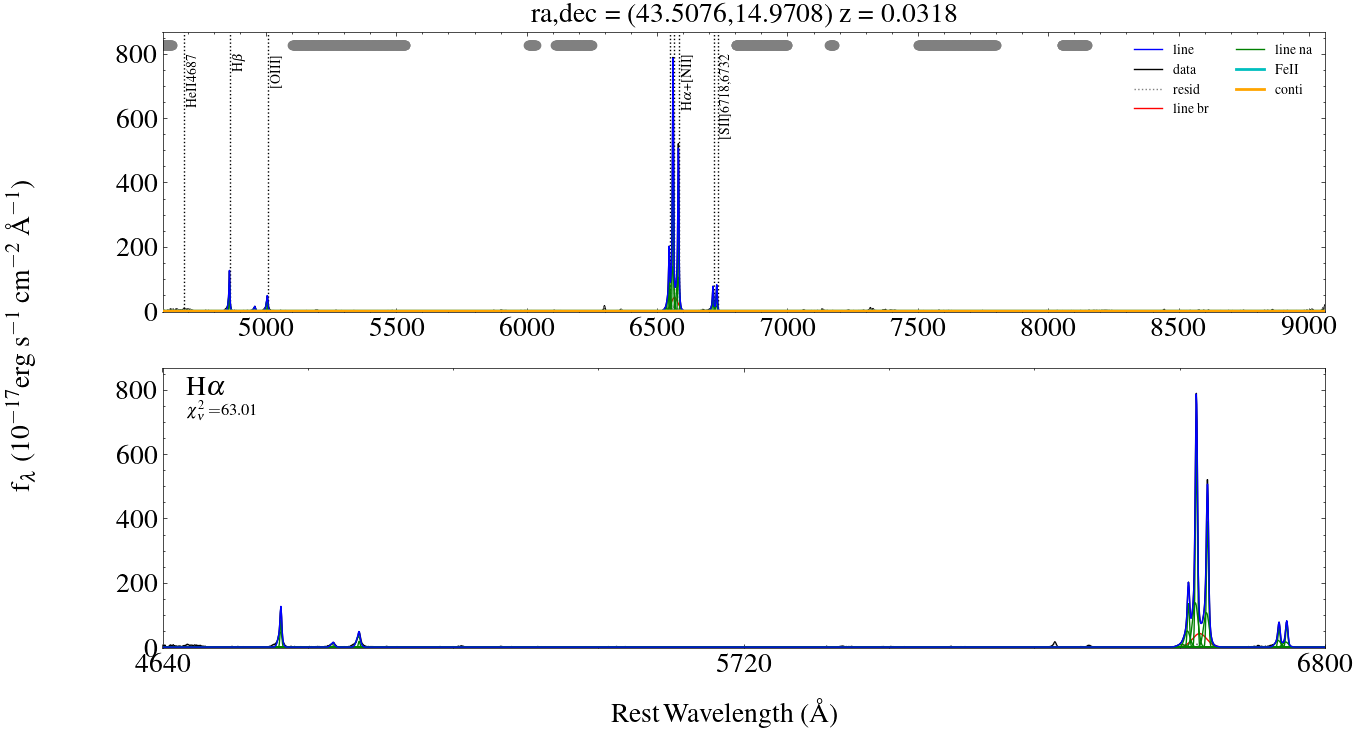

In [21]:
# Prepare data
goodpixind=~((lam<6050) &(lam>5779))

q_mle = pyqsofit.PyQSOFit.QSOFit(lam[goodpixind], flux[goodpixind], err[goodpixind], z, ra=RA[int(obj)-1], dec=Dec[int(obj)-1], path=path_ex)#plateid=plateid, mjd=mjd, fiberid=fiberid,ra=ra, dec=dec,

# Double check the installation path with the PCA / Fe template files
#print('install path:', q_mle.install_path)

# Change it if you installed them somewhere else
#q_mle.install_path = '...'

start = timeit.default_timer()
# Do the fitting
#continterp=np.interp(q_mle.wave,contwave,cont)

q_mle.Fit(num_abs_line=4,
          Cf=[0.8,0.0,1.0],
          nline=[2,2], #the number of absorption lines in each abs_ncomp velocity component.
          abs_ncomp=2, #the number of different velocity components for absorption lines.
          external_cont=np.array([contwave,cont*1e-3]),
          name=None,  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=None,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=False,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied
          host_prior=False, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
          host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

          host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
          decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
          qso_type='CZBIN1', # PCA template name for quasar
          npca_qso=10, # numebr of quasar templates
          host_type='PCA', # template name for galaxy
          npca_gal=5, # number of galaxy templates
          
          # continuum model fit parameters
          do_continumm=False, # ignore the whole continuum fitting process with MCMC
          Fe_uv_op=False,  # If True, fit continuum with UV and optical FeII template
          poly=False,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=False,  # If True, it will iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected.

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted
          rej_abs_line=False,
          # If True, it will iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=2000,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          param_file_name='qsopar_obj{}_{}.fits'.format(obj,instru),  # Name of the qso fitting parameter FITS file.
          nburn=100,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=False,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=None,  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=True,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=True,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=True,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

## Sorting result and make figures

In [7]:
pname=q.gauss_result_name[::2]
lines=['_'.join(pname[nn*3].split('_')[:-2]) for nn in range(int(len(pname) / 3))]
print(lines)

['NaI5890', 'NaI5890w', 'Ha_br', 'Ha_na', 'NII6585', 'SII6732', 'Ha_naw', 'NII6585w', 'SII6732w', 'Hb_naw', 'OIII5007c', 'OIII5007w']


In [ ]:
select="Ha_na"
line_ind=lines.index(select)
line_area=np.zeros(q.gauss_result_all.shape[0])
for n_samp in range(q.gauss_result_all.shape[0]):
    f_lam=q.Onegauss(np.log(q.wave), q.gauss_result_all[n_samp,line_ind * 3:(line_ind + 1) * 3])
    line_area[n_samp]=np.trapz(f_lam,x=q.wave)

#plt.plot(q.wave, q.Onegauss(np.log(q.wave), res_nsamp[line_ind * 3:(line_ind + 1) * 3]), color="red")
#plt.xlim([6500,6700])
#plt.axvline(6564.63)

In [112]:
np.save(datapath+"/MUSE_gauss_result_abs_obj{}".format(obj),q.gauss_result_all)
np.save(datapath+"/MUSE_gauss_result_abs_wave_obj{}".format(obj),np.array([q.wave,q.line_flux,q.external_cont]))
np.save(datapath+"/MUSE_gauss_result_abs_sup_obj{}".format(obj),q.gauss_result_name)

In [268]:
gauss_all=np.load(datapath+"/MUSE_gauss_result_abs_obj{}.npy".format(obj))
wave_spec=np.load(datapath+"/MUSE_gauss_result_abs_wave_obj{}.npy".format(obj))
gauss_names=np.load(datapath+"/MUSE_gauss_result_abs_sup_obj{}.npy".format(obj))

In [25]:
pp=q_mle.gauss_result_name
ngauss = len(pp[:-q_mle.abs_ncomp]) // 3
pp_shaped = np.reshape(pp[:-q_mle.abs_ncomp], (ngauss, 3)) #excluding the absorber covering fractions Cf_n
pp_shaped_abs = pp_shaped[:q_mle.num_abs_line,:]
pp_shaped = pp_shaped[q_mle.num_abs_line:,:]
print(pp[-q_mle.abs_ncomp:])

            #q_mle.gauss_result_name[:-q_mle.ga]

['Cf_0' 'Cf_1']


In [31]:
ngauss

23

## making figure: non-MCMC

In [8]:
ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

In [9]:
import pandas as pd
#print(q_mcmc.line_result_name)
#print('')
#print(q_mcmc.line_result)
q=q_mle
line_result=pd.DataFrame({"value":q.line_result},index=q.line_result_name)
print(line_result)

                                value
1_complex_name                     Ha
1_line_status                       1
1_line_min_chi2     96344.40280389471
1_line_bic          6723.170120758208
1_line_red_chi2     63.01138182072905
...                               ...
Ha_whole_br_sigma   662.2979574208362
Ha_whole_br_ew                    inf
Ha_whole_br_peak    6566.232845244217
Ha_whole_br_area   1387.3942593203994
Ha_whole_br_snr     48.75197619015818

[84 rows x 1 columns]


In [10]:
q.linelist

FITS_rec([(5889.95 , 'Ha', 4640., 6800., 'NaI5890', 1, 1., 0., 1.e+01, 1.e-05, 2.3e-07, 0.0169 , 0.005, 4, 0, 1, 0.2  , 1),
          (5895.924, 'Ha', 4640., 6800., 'NaI5896', 1, 1., 0., 1.e+01, 1.e-05, 2.3e-07, 0.0169 , 0.005, 4, 0, 1, 0.1  , 1),
          (5889.95 , 'Ha', 4640., 6800., 'NaI5890w', 1, 1., 0., 1.e+01, 1.e-05, 2.3e-07, 0.0169 , 0.005, 5, 0, 2, 0.2  , 1),
          (5895.924, 'Ha', 4640., 6800., 'NaI5896w', 1, 1., 0., 1.e+01, 1.e-05, 2.3e-07, 0.0169 , 0.005, 5, 0, 2, 0.1  , 1),
          (6564.61 , 'Ha', 4640., 6800., 'Ha_br', 2, 0., 0., 1.e+10, 5.e-03, 4.0e-04, 0.05   , 0.015, 0, 0, 0, 0.05 , 1),
          (6564.61 , 'Ha', 4640., 6800., 'Ha_na', 1, 0., 0., 1.e+10, 1.e-03, 2.3e-07, 0.00169, 0.01 , 1, 1, 0, 0.002, 1),
          (6549.85 , 'Ha', 4640., 6800., 'NII6549', 1, 0., 0., 1.e+10, 1.e-03, 2.3e-07, 0.00169, 0.005, 1, 1, 0, 0.001, 1),
          (6585.28 , 'Ha', 4640., 6800., 'NII6585', 1, 0., 0., 1.e+10, 1.e-03, 2.3e-07, 0.00169, 0.005, 1, 1, 0, 0.003, 1),
          

In [11]:
q.gauss_result.shape

(71,)

In [12]:
q.gauss_result[::2]

array([7.51512592e-01, 1.45552789e-05, 8.68202137e+00, 7.51514542e-01,
       1.45553228e-05, 8.68202137e+00, 4.20770352e+01, 2.00855538e-03,
       8.78464929e+00, 6.28523331e+02, 2.94429282e-04, 8.78665239e+00,
       3.97138402e+02, 2.94429282e-04, 8.81204397e+00, 6.73742850e+01,
       2.94429282e-04, 8.67802221e+00, 1.37915853e+02, 7.80872417e-04,
       8.78632953e+00, 1.07099246e+02, 7.80872417e-04, 8.81172111e+00,
       1.58470731e+01, 7.80872417e-04, 8.48880082e+00, 4.69355749e+01,
       7.80872417e-04, 8.50867635e+00, 1.85717897e+01, 2.94429282e-04,
       8.50835350e+00, 3.28281807e+01, 7.80872417e-04, 5.63933471e-01])

result for obj3
line shift: 8.488477972073836
Old redshift z = 0.031800
Best-fitting redshift z = 0.030906

line shift: 3.5725818950259054
velocity shift of Ha_na: -163.152588
Old redshift z = 0.031800
Best-fitting redshift z = 0.031238

OIII5007c:
FWHM (km/s) 210.5
Sigma (km/s) 86.4
EW (A) inf
Peak (A) 5005.5
Area (10^(-17) erg/s/cm^2) 68.3

OIII4959c:
FWHM (km/s) 210.5
Sigma (km/s) 86.4
EW (A) inf
Peak (A) 4957.6
Area (10^(-17) erg/s/cm^2) 15.2

Ha_naw:
FWHM (km/s) 555.7
Sigma (km/s) 230.6
EW (A) inf
Peak (A) 6558.1
Area (10^(-17) erg/s/cm^2) 1765.4

Hb_naw:
FWHM (km/s) 555.7
Sigma (km/s) 230.6
EW (A) inf
Peak (A) 4857.9
Area (10^(-17) erg/s/cm^2) 445.0

NII6549:
FWHM (km/s) 210.5
Sigma (km/s) 86.4
EW (A) inf
Peak (A) 6546.3
Area (10^(-17) erg/s/cm^2) 652.8

NII6585:
FWHM (km/s) 210.5
Sigma (km/s) 86.4
EW (A) inf
Peak (A) 6581.7
Area (10^(-17) erg/s/cm^2) 1920.0

SII6718:
FWHM (km/s) 210.5
Sigma (km/s) 86.4
EW (A) inf
Peak (A) 6714.6
Area (10^(-17) erg/s/cm^2) 283.2

SII6732:
FWHM (k

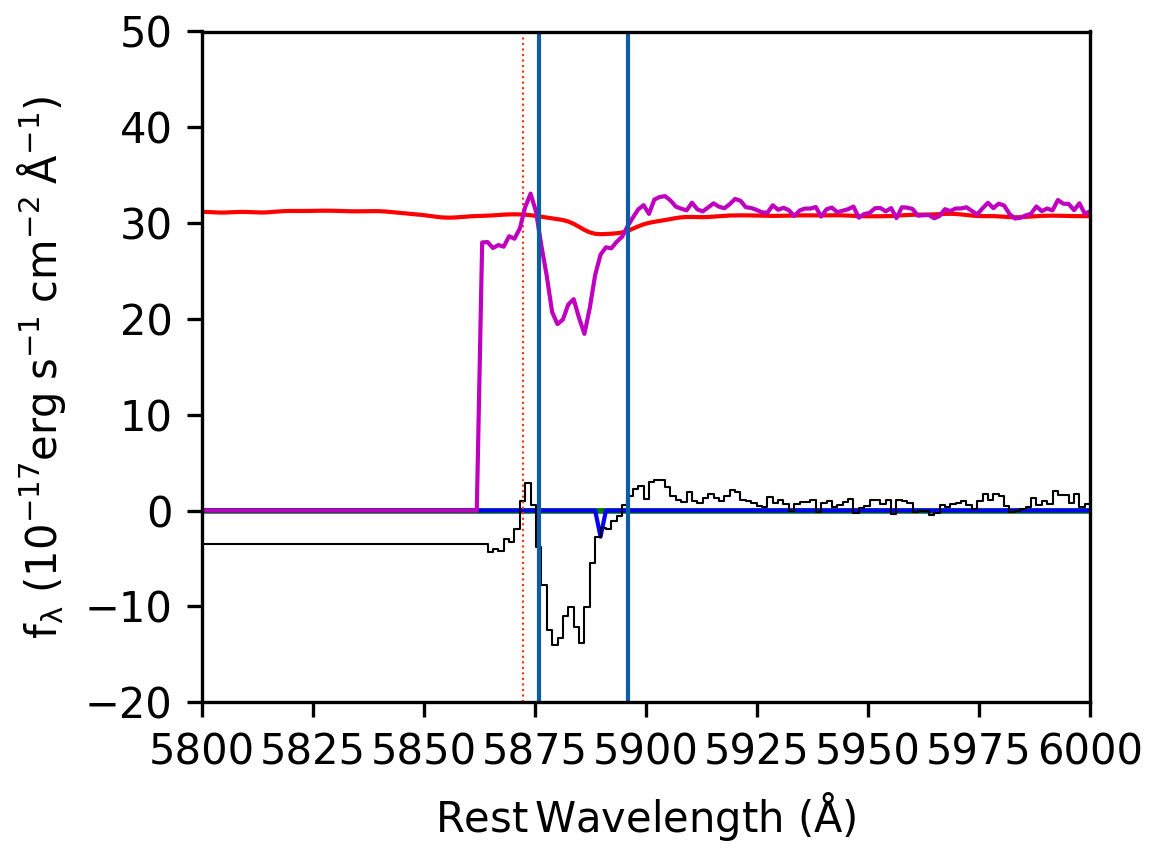

In [22]:
plt.rcdefaults()
import scienceplots

fig, ax = plt.subplots(1, 1,figsize=(4,3), dpi=300)
plt.style.use(["science"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
q=q_mle

if q.MCMC:
    gauss_result = q.gauss_result[::2]
else:
    gauss_result = q.gauss_result

# Plot individual line components
if q.num_abs_line > 0:
    start_emission=q.num_abs_line
for p in range(start_emission,int(len(gauss_result) / 3)):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

for p in range(start_emission):
    if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model

ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=1)
ax.step(q.wave, q.line_flux, 'k',lw=0.5)
xlow=5800
xhigh=6000
ax.set_xlim(xlow, xhigh)
#yup=np.max(q.line_flux)
yup=50
ylow=-20
ax.set_ylim(ylow,yup)
#ax.set_yscale("log")
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)')
'''
Line properties
'''
print("result for obj{}".format(obj))

from astropy import constants
from astropy import units as u
c=constants.c.to(u.km/u.s).value
#linename="OIII5007c"
linename="Hb_naw"
#linename="H2_S1"
#lineshift=np.exp(float(line_result.loc["{}_1_centerwave".format(linename)]))-4862.68
lineshift=float(line_result.loc["{}_1_centerwave".format(linename)])
linec=np.exp(float(line_result.loc["{}_1_centerwave".format(linename)]))
#flinecerr=linec*float(line_result.loc["{}_1_centerwave_err".format(linename)]) #these are tied together


zf=1+z
zfpec = linec/4862.68
#ax.plot(contwave/zf,cont*1e-3,"m")
#vpec =  (linec/4862.68-1)*c                     # This is the fitted residual velocity in km/s
#dvpec = flinecerr/4862.68*c
#znew = (1 + z)*np.exp(vpec/c) - 1           # eq.(5c) Cappellari (2023)
znew = zf*zfpec-1
#dznew = (1 + znew)*dvpec/c              # eq.(5d) Cappellari (2023)
#dznew = znew*flinecerr/linec
print(f"line shift: {lineshift}")
#print(f"velocity shift of {linename:s}: {vpec:#.6f}") #+/- {dvpec:#.2g}")
print(f"Old redshift z = {z:#.6f}")
print(f"Best-fitting redshift z = {znew:#.6f}")# +/- {dznew:#.2g}")
print("")

linename="Ha_na"
#lineshift=float(line_result.loc["{}_1_centerwave".format(linename)])
linec=np.exp(float(line_result.loc["{}_1_centerwave".format(linename)]))
lineshift=6564.61-linec
#flinecerr=linec*float(line_result.loc["{}_1_centerwave_err".format(linename)])

zfpec = linec/6564.61
vpec =  (linec/6564.61-1)*c                     # This is the fitted residual velocity in km/s
#dvpec = flinecerr/6564.61*c
#znew = (1 + z)*np.exp(vpec/c) - 1           # eq.(5c) Cappellari (2023)
znew = zf*zfpec-1
#dznew = (1 + znew)*dvpec/c              # eq.(5d) Cappellari (2023)
#dznew = znew*flinecerr/linec
print(f"line shift: {lineshift}")
print(f"velocity shift of {linename:s}: {vpec:#.6f}") #+/- {dvpec:#.2g}")
print(f"Old redshift z = {z:#.6f}")
print(f"Best-fitting redshift z = {znew:#.6f}")# +/- {dznew:#.2g}")
print("")

#NII6549w_1_scale)      = -0.1871
#    C(Ha_br_2_scale, SII6718w_1
all_area={}
all_peaks={}
ln_to_print=['OIII5007c','OIII4959c','Ha_naw','Hb_naw',"NII6549","NII6585","SII6718","SII6732",'Ha_na','Hb_na',"HeI5876"]#,"NaI5890","NaI5896"]
text=[r'[OIII]$\,$5007',r'[OIII]$\,$4959',r'H$\alpha$',r'H$\beta$',r"[NII]$\,$6549",r"[NII]$\,$6585",r"[SII]$\,$6718",r"[SII]$\,$6732"]

for ind,ln in enumerate(ln_to_print):
    if "br" in ln:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'broad')
    else:
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(ln, 'narrow')
    all_area[ln]=area
    all_peaks[ln]=peak
    print("{}:".format(ln))
    print("FWHM (km/s)", np.round(fwhm, 1))
    print("Sigma (km/s)", np.round(sigma, 1))
    print("EW (A)", np.round(ew, 1))
    print("Peak (A)", np.round(peak, 1))
    print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
    print("")
    if peak > xhigh or peak < xlow:
        continue
    ax.axvline(peak,color="C{}".format(ind),lw=0.5,ls=":")
    try:
        ax.text(peak*0.999, 5e-1*yup,text[ind], rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
    except:
        print(ln,"doesn't have a text label!")
        
ax.plot(lam/(1+z),continterp*1e-3,"r")
ax.plot(lam/(1+z),data[:,1]*1e-3,"m")
#ax.plot(lam/(1+z),err,"k")
#ax.axvline(5890)
ax.axvline(5896)
ax.axvline(5876)
plt.tight_layout()
#fig.savefig(datapath+"/fig/MUSE_obj{}.pdf".format(obj))

In [99]:
def search_pattern_in_array(arr, pattern="Cf"):
    """
    Searches for a given pattern in a NumPy array of strings.
    
    Parameters:
    arr (np.ndarray): NumPy array of strings to search within.
    pattern (str): Pattern to search for in each string.
    
    Returns:
    np.ndarray: Array of strings containing the pattern.
    """
    # Use np.char.find to get indices where the pattern is found
    match_indices = np.char.find(arr, pattern) >= 0  # Boolean mask
    return arr[match_indices]

# Example usage
matching_strings = search_pattern_in_array(q.line_result_name)
print(matching_strings)

['Cf_0' 'Cf_1']


In [105]:
q.line_result_name.shape

(159,)

## Generating EW for NaID

In [383]:
linename="NaI5896"

ind_ini=np.where(q.gauss_result_name=="NaI5890_1_scale")[0][0]

param=q.gauss_result[ind_ini:ind_ini+3]
#linec=np.exp(float(line_result.loc["{}_1_centerwave".format(linename)]))

out_conti=np.interp(q.wave,contwave,cont)
f_lam=q.Onegauss(np.log(q.wave), param)+out_conti*1e-3


line_area=np.trapz(f_lam[abs_ind],x=q.wave[abs_ind])

EW=line_area/np.trapz(out_conti[abs_ind]*1e-3,x=q.wave[abs_ind])

In [384]:
line_reg_ind=np.where(q.gauss_result_name=="NaI5890_1_scale")[0]

0.9847517734162845

In [439]:
q.num_abs_line

2

In [381]:
abs_ind=abs_f<-1e-2

In [372]:
np.exp(8.68107932)

5890.400788992586

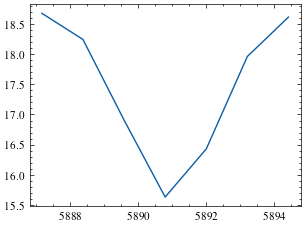

In [382]:
plt.plot(q.wave[abs_ind],f_lam[abs_ind])

In [128]:
from astropy.cosmology import Planck18
SA=Planck18.luminosity_distance(0.0312).to(u.cm)**2*4*np.pi
0.95*np.log10(457.6e-17*SA.value)+3.89

41.92798420679962

In [336]:
q.gauss_result

array([ 1.02319557e+02,  8.78937940e+00,  4.95438291e-04,  1.79535953e+01,
        8.78712777e+00,  4.95438291e-04,  4.83493595e+01,  8.79252271e+00,
        4.95438291e-04,  1.80016418e+01,  8.81251935e+00,  4.95438291e-04,
        1.38378947e+01,  8.81465749e+00,  4.95438291e-04,  6.51179000e+00,
        8.67849759e+00,  4.95438291e-04, -2.95371437e+00,  8.68107932e+00,
        2.20810874e-04, -6.57672882e-02,  8.68209308e+00,  2.20810874e-04,
        5.63811839e+02,  8.78952544e+00,  2.20810874e-04,  6.42606079e+01,
        8.78727382e+00,  2.20810874e-04,  1.97361892e+02,  8.79266875e+00,
        2.20810874e-04,  6.52320092e+01,  8.81266539e+00,  2.20810874e-04,
        5.43268636e+01,  8.81480353e+00,  2.20810874e-04,  4.38539371e+01,
        8.48927621e+00,  4.95438291e-04,  1.19506756e+02,  8.48942225e+00,
        2.20810874e-04,  3.68401698e+00,  8.50915174e+00,  4.95438291e-04,
        1.29129030e+01,  8.51877050e+00,  4.95438291e-04,  3.87224475e+00,
        8.50929778e+00,  

In [98]:
from dust_attenuation.averages import C00
Cex=C00()

In [54]:
all_area

{'OIII5007w': 80.58972657969765,
 'OIII4959w': 21.789950861216155,
 'Ha_naw': 2144.5587838064025,
 'Hb_naw': 230.54526591454626,
 'NII6549w': 445.65694688327255,
 'NII6585w': 1428.182661955051,
 'SII6718w': 162.3768680690234,
 'SII6732w': 213.94720511305445}

In [182]:
#print(r"H$_2$/Br$\gamma$",all_area['H2_10_S1']/all_area['Brg_na'])
#print("H_2/Br gamma",all_area['H2_10_S1']/all_area['Brg_na'])
#EBV=2.5/1.163*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.68))
EBV=2.5/(Cex.k_lambda(x=[0.486268])-Cex.k_lambda(x=[0.656461]))*np.log10(((all_area['Ha_naw']+all_area['Ha_na'])/(all_area['Hb_naw']+all_area['Hb_na'])/2.86))

print(EBV)

[0.46206538]


In [183]:
from dust_attenuation.averages import C00
Cex=C00()
wave=[]
for key in all_peaks:
    if all_peaks[key]/10000 > 2.2:
        continue
    else:
        wave.append(all_peaks[key]/10000)
Alambda=Cex.k_lambda(x=wave)*EBV
print(Cex.k_lambda(x=[0.5500])*EBV)

[1.87039001]


In [184]:
print(Cex.k_lambda(x=[0.5500])*0.69)

[2.79304436]


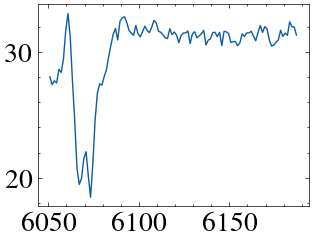

In [90]:
xlow=5867
xhigh=6000
line_ind=(lam/(1+z)>xlow)&(lam/(1+z)<xhigh)

plt.plot(lam[line_ind],data[:,1][line_ind]*1e-3)

In [387]:
# Requried
data = np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))
lam = data[:,0]  # OBS wavelength [A]
#flux = data[:,1]*1e-3  # OBS flux [1e-17 erg/s/cm^2/A]
err = data[:,2]*1e-3  # 1 sigma error

#continuum
cont=np.loadtxt(os.path.join(path_out, "{}_nuclear_spec_ppxfmodel_r0.75_obj{}.txt".format(instru.split("_")[0],obj)))*1e20 # to 1e-20
contwave=np.loadtxt(os.path.join(path_out, "wave_ln_binned.txt"))
continterp=np.interp(lam,contwave,cont)
flux=(data[:,1]-continterp)*1e-3




# create FITS file containing fitting parameter setup 
hdr0 = fits.Header()
hdr0['Author'] = 'Yuanze Ding'
primary_hdu = fits.PrimaryHDU(header=hdr0)

"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

line_priors = np.rec.array([
    (5889.950, 'Ha', 4640, 6800, 'NaI5890w', 1, 1e1, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 5, 5, 0, 0.001, 1),
    (5895.924, 'Ha', 4640, 6800, 'NaI5896w', 1, 1e1, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 5, 5, 0, 0.001, 1),
    #(6564.61, 'Ha', 4640, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6549.85, 'Ha', 6400, 6800, 'NII6549_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(6585.28, 'Ha', 6400, 6800, 'NII6585_br', 2, 0.0, 0.0, 1e10, 5e-3, 4e-4, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 4640, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.003, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    (5875.621, 'Ha', 4640, 6800, 'HeI5876', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 1, 1, 0, 0.001, 1),
    
    

    
#    (8498.02, 'Ha', 6400, 6800, 'CaII8498', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8542.09, 'Ha', 6400, 6800, 'CaII8542', 1, 0.0, -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
#    (8662.14, 'Ha', 6400, 6800, 'CaII8662', 1, 0.0,  -1e10, 0.0, 1e-3, 2.3e-5, 0.00169, 5e-3, 7, 7, 0, 0.001, 1),
    
    (6564.61, 'Ha', 4640, 6800, 'Ha_naw',  1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7,  0.00169, 0.01, 3, 3, 0, 0.002, 1),
    (6549.85, 'Ha', 4640, 6800, 'NII6549w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),
    (6585.28, 'Ha', 4640, 6800, 'NII6585w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.003, 1),
    (6718.29, 'Ha', 4640, 6800, 'SII6718w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),
    (6732.67, 'Ha', 4640, 6800, 'SII6732w', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 5e-3, 3, 3, 0, 0.001, 1),

    #(4862.68, 'Ha', 4640, 6800, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3,  4e-4,  0.05,        0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169,     0.01, 1, 1, 0, 0.002, 1),
    (4862.68, 'Ha', 4640, 6800, 'Hb_naw', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169,    0.01, 3, 3, 0, 0.002, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-7, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Ha', 4640, 6800, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, 0.01, 3, 3, 0, 0.001, 1),
    (5008.24, 'Ha', 4640, 6800, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-7, 0.004, 0.01, 3, 3, 0, 0.002, 1)
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    (19700.,20250.),
    (21700.,22250.)
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  0), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 0), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  0), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 0), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  0), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     0.0,   0.0,   1e10,  0), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   0), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  0), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 0), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.0,   0.1,   2.0,   0), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  0), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  0), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  0), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[4600, 5100, 6400, 8000,20000,20900]],
        [[
            # [2240, 2650], 
            [5100, 5485],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar_obj{}_{}_abs.fits'.format(obj,instru)), overwrite=True)